In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import time
from IPython import display
from astropy.io import fits
from tqdm.notebook import tqdm
import os
import skimage.morphology
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from reproject.mosaicking import find_optimal_celestial_wcs
from astropy.wcs import WCS

In [2]:
def show_images(images, num):
    """
    Visualising the images
    """
    
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(cols*4, rows*4))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]
        plt.imshow(image, cmap='inferno', origin='lower')
        plt.axis('off')
    plt.show() 

In [12]:
ims = np.load(r"Data arrays\all_cuts_unedited.npy",  allow_pickle = True)[:5848]
ims = np.reshape(ims, (86, 68, 128, 128), order='F')

print(ims.shape)

(86, 68, 128, 128)


C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


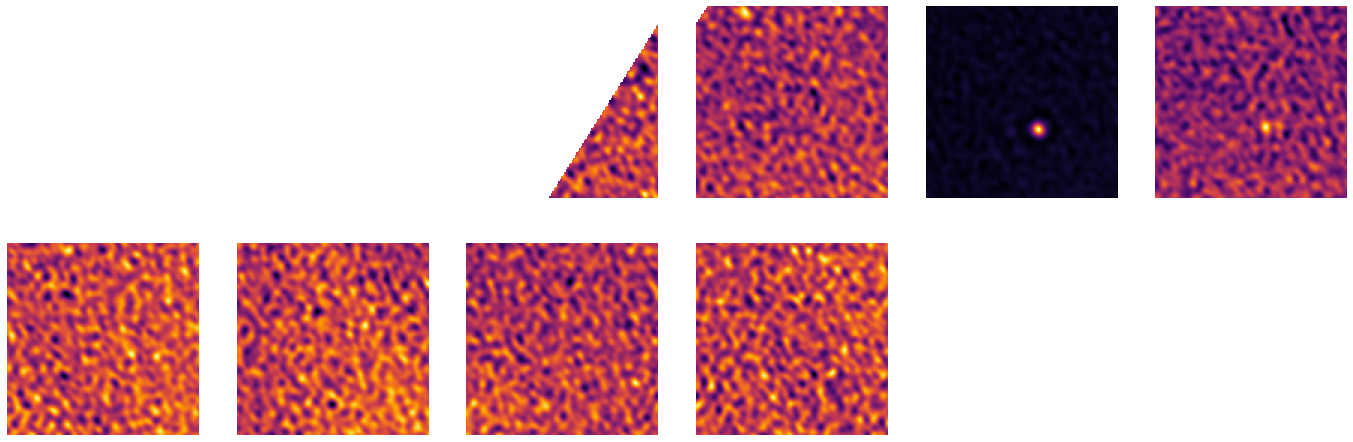

In [13]:
show_images(ims[85], 10)

In [79]:
pred = np.load(r"Data arrays\predictions.npy",  allow_pickle = True)
print(pred.shape)

(86, 68)


In [80]:
loc = np.argwhere(pred)

In [81]:
x = []
y = []
for i in range(len(loc)):
    x.append(loc[i][0])
    y.append(loc[i][1])

In [82]:
dense = np.zeros((len(loc),len(loc)), dtype=bool)
dense[y,x] = True

labeled = skimage.morphology.label(dense, connectivity=2)

In [83]:
coords = { i: (labeled == i).nonzero() for i in range(1,labeled.max()+1) }

len(coords)

151

In [41]:
# i = 1
# f = 0
# padding=  True
# while i < len(coords)+1:
#     x = coords[i][0]
#     y = coords[i][1]
#     if len(x)*len(y) > 1 and len(x)*len(y) < 30:
#         y_norm = (y-y.min())+1
#         x_norm = (x-x.min())+1
#         canvas = np.zeros(((y_norm.max()+2)*128, (x_norm.max()+2)*128))
#         for j in range(len(y)):
#             canvas[y_norm[j]*128:(y_norm[j]+1)*128, x_norm[j]*128:(x_norm[j]+1)*128] = ims[y[j]][x[j]]
#             if padding:
#                 if y[j]<85:
#                     canvas[(y_norm[j]+1)*128:(y_norm[j]+2)*128, (x_norm[j])*128:(x_norm[j]+1)*128] = ims[y[j]+1][x[j]]
#                 if y[j]>0:
#                     canvas[(y_norm[j]-1)*128:(y_norm[j])*128, (x_norm[j])*128:(x_norm[j]+1)*128] = ims[y[j]-1][x[j]]
#                 if x[j]<67:
#                     canvas[(y_norm[j])*128:(y_norm[j]+1)*128, (x_norm[j]+1)*128:(x_norm[j]+2)*128] = ims[y[j]][x[j]+1]
#                 if x[j]>0:
#                     canvas[(y_norm[j])*128:(y_norm[j]+1)*128, (x_norm[j]-1)*128:(x_norm[j])*128] = ims[y[j]][x[j]-1]
#         canvas = canvas.astype('float')
#         canvas[canvas == 0] = np.nan
#         #plt.imshow(canvas)
#         np.save(r"Data arrays\Mosaics\mosaic{}.npy".format(f), canvas)
#         f+=1
#     else:
#         pass
#     i+=1

In [3]:
import pickle

with open('coords.p', 'rb') as fp:
    coords = pickle.load(fp)

In [25]:
HDUList = fits.open(r"Data arrays\all_cuts3.fits")

In [26]:
len(HDUList)

5848

In [27]:
num_b = 86
num_a = 68
padding=True

i = 1
f = 0
N = num_a*num_b
super_HDUList = fits.HDUList([])
pbar = tqdm(total=len(coords))
while i < len(coords)+1:
    x = coords[i][0]
    y = coords[i][1]

    if len(x)*len(y) > 1:   

        sub_HDUList = fits.HDUList([])
        j=0
        while j < len(y):
            sub_HDUList.append(HDUList[num_b*x[j]+y[j]])

            if padding:
                if num_b*(x[j]+1)+y[j] <= N:
                    sub_HDUList.append(HDUList[num_b*(x[j]+1)+y[j]])
                if num_b*(x[j]-1)+y[j] <= N:
                    sub_HDUList.append(HDUList[num_b*(x[j]-1)+y[j]])
                if num_b*(x[j])+y[j]+1 <= N:
                    sub_HDUList.append(HDUList[num_b*(x[j])+y[j]+1])
                if num_b*(x[j])+y[j]-1 <= N:
                    sub_HDUList.append(HDUList[num_b*(x[j])+y[j]-1])
                if num_b*(x[j]+1)+y[j]+1 <= N:
                    sub_HDUList.append(HDUList[num_b*(x[j]+1)+y[j]+1])
                if num_b*(x[j]-1)+y[j]+1 <= N:
                    sub_HDUList.append(HDUList[num_b*(x[j]-1)+y[j]+1])
                if num_b*(x[j]+1)+y[j]-1 <= N:
                    sub_HDUList.append(HDUList[num_b*(x[j]+1)+y[j]-1])
                if num_b*(x[j]-1)+y[j]-1 <= N:
                    sub_HDUList.append(HDUList[num_b*(x[j]-1)+y[j]-1])
            j+=1

        wcs_out, shape_out = find_optimal_celestial_wcs(sub_HDUList)
        array, footprint = reproject_and_coadd(sub_HDUList, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
        new_header = wcs_out.to_header()
        hdu = fits.PrimaryHDU(array, header=new_header)
        super_HDUList.append(hdu)           

    else:
        pass

    pbar.update(1)
    i+=1

print(str(len(super_HDUList)) + " Filament regions detected. ")

  0%|          | 0/72 [00:00<?, ?it/s]

41 Filament regions detected. 


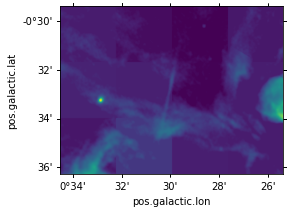

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


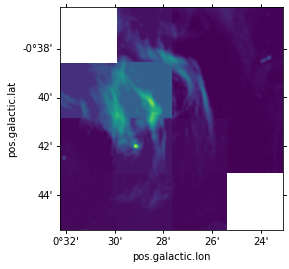

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


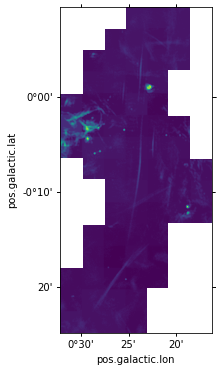

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


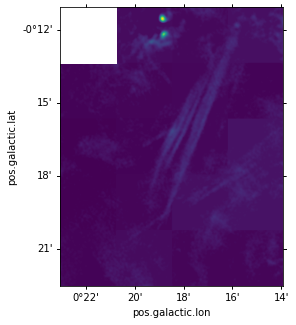

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


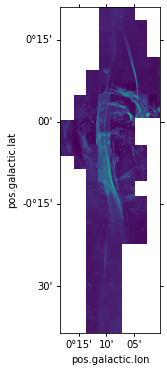

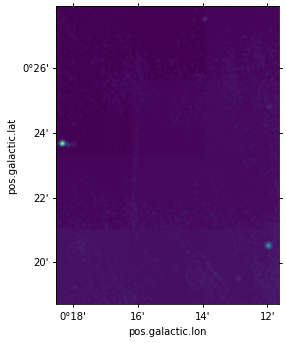

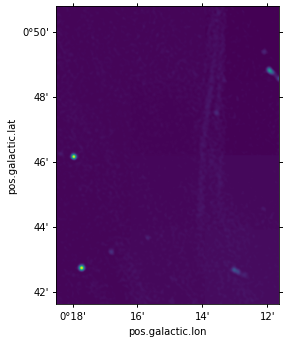

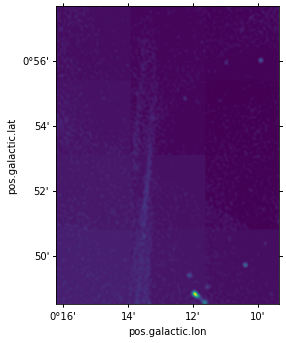

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


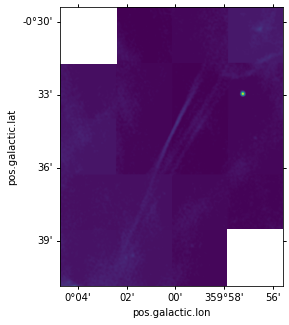

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


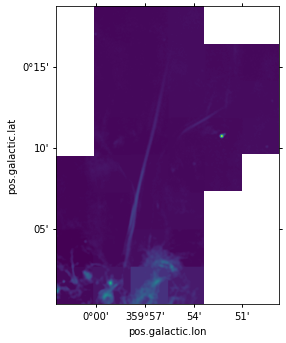

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


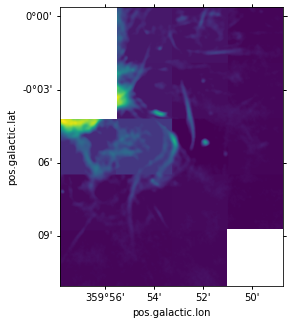

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


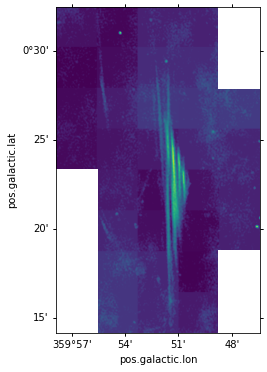

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


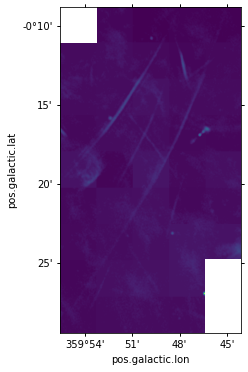

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


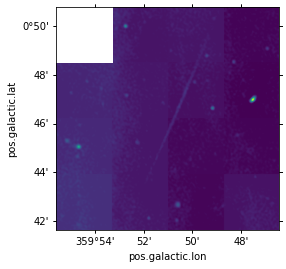

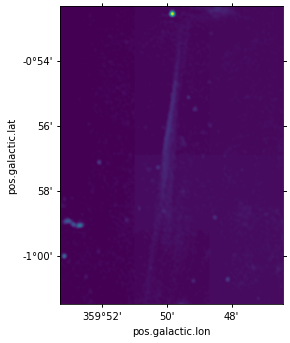

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


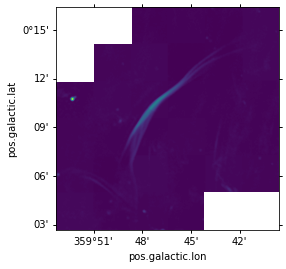

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


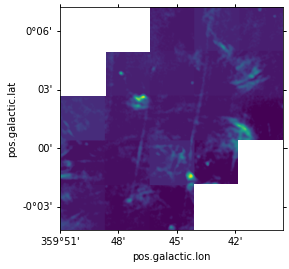

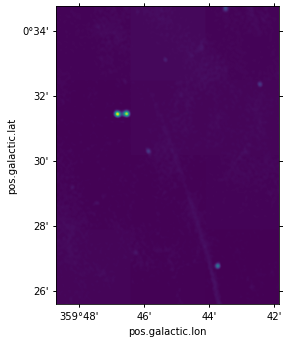

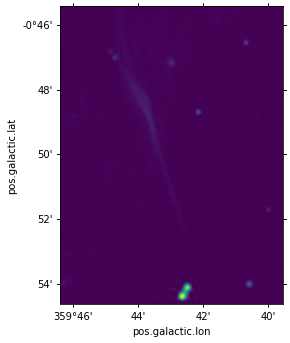

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


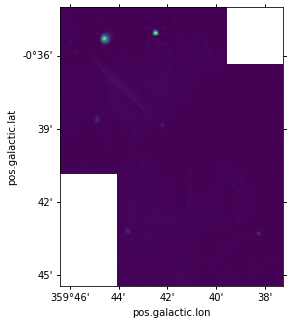

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


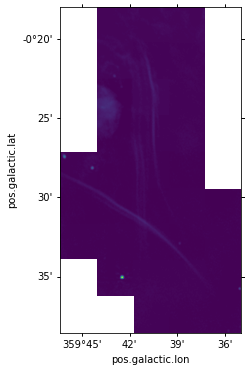

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


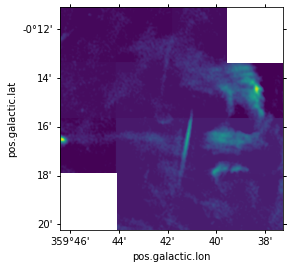

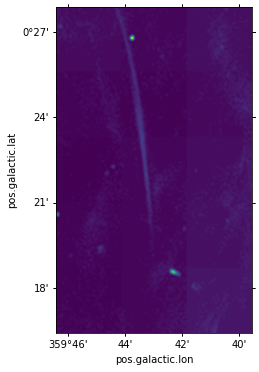

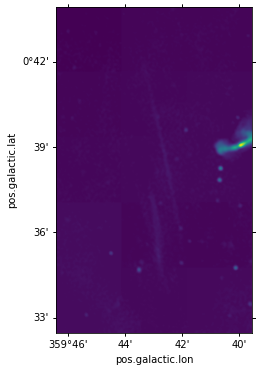

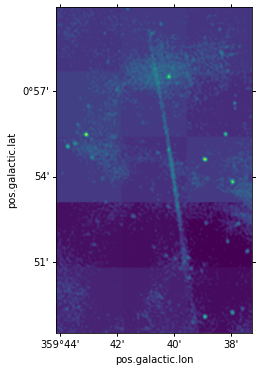

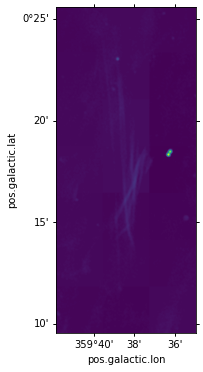

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


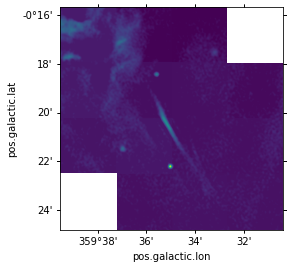

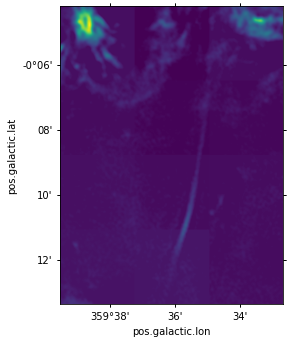

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


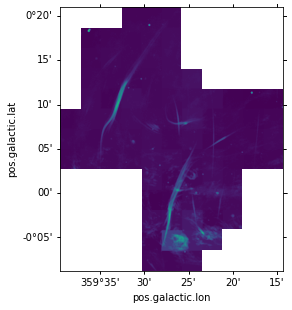

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


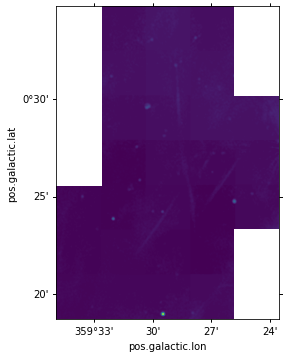

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


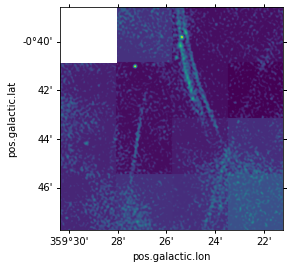

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


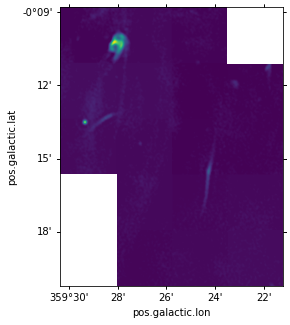

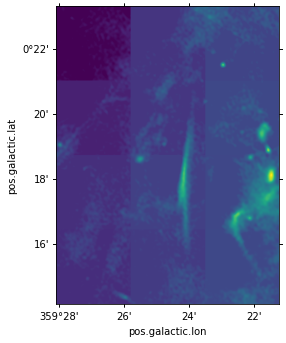

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


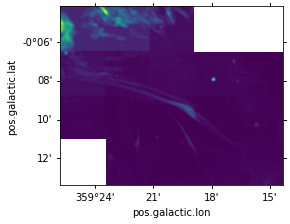

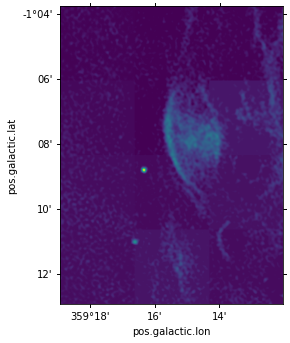

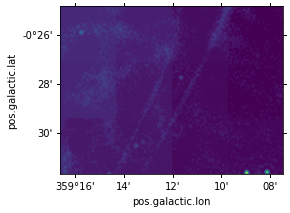

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


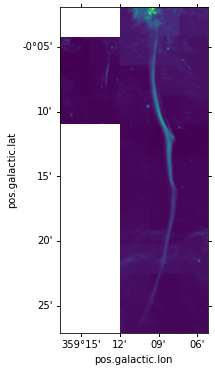

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


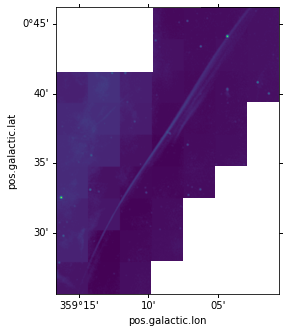

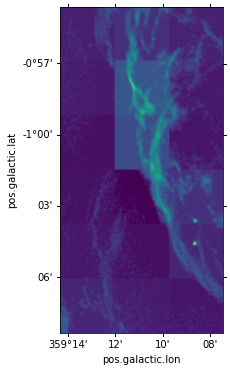

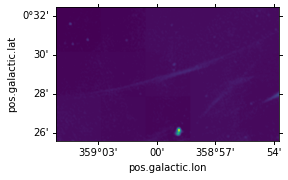

C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\shari\anaconda3\envs\gpu\lib\site-packages\matplotlib\colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


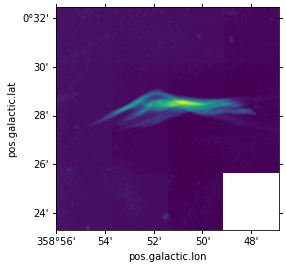

In [28]:
for i in range(len(super_HDUList)):
    
    hdu = super_HDUList[i]
    plt.figure(figsize=(4,6))
    wcs = WCS(hdu.header)
    plt.subplot(projection=wcs) 
    plt.imshow(hdu.data, origin='lower', norm=colors.LogNorm()) 
    #plt.grid(color='k', ls='solid')
    plt.show()